In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns 

### Prepare the Data

In [28]:
df_ataque = pd.read_csv("psutil-stats-con-ataque.csv")
df_sin_ataque = pd.read_csv("psutil-stats-sin-ataque.csv")

In [29]:
df_ataque.shape

(1102, 17)

In [30]:
df_sin_ataque.shape

(972, 17)

In [31]:
df_sin_ataque = df_sin_ataque.head(972)

In [32]:
df_ataque = df_ataque.drop(columns=['Timestamp'])
df_sin_ataque = df_sin_ataque.drop(columns=['Timestamp'])
df_sin_ataque = df_sin_ataque.iloc[1:]
df_ataque = df_ataque.iloc[1:]

In [33]:
df_sin_ataque['Target'] = 0
df_ataque['Target'] = 1

In [35]:
# Concat attack and non-attack datasets
X = pd.concat([df_sin_ataque, df_ataque], axis=0)

### Remove Outliers

In [37]:
def remove_outliers(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
    df_processed = df.mask(outliers)
    df_processed = df_processed.dropna()
    
    return df_processed
    

In [38]:
X = remove_outliers(X)

### Data Splitting

In [41]:
y = X['Target']

In [42]:
X = X.drop(columns=['Target'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Model training

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
clf = Pipeline(
    [
        ("standard", StandardScaler()),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

In [56]:
clf.fit(X_train,y_train)

Pipeline(steps=[('standard', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [57]:
prediction = clf.predict(X_test)

In [58]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       155

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



### Feature Importance

In [60]:
feature_importance = np.array(clf.named_steps["classifier"].feature_importances_)

In [61]:
features = np.array(df_ataque.columns)[0:16]

In [62]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

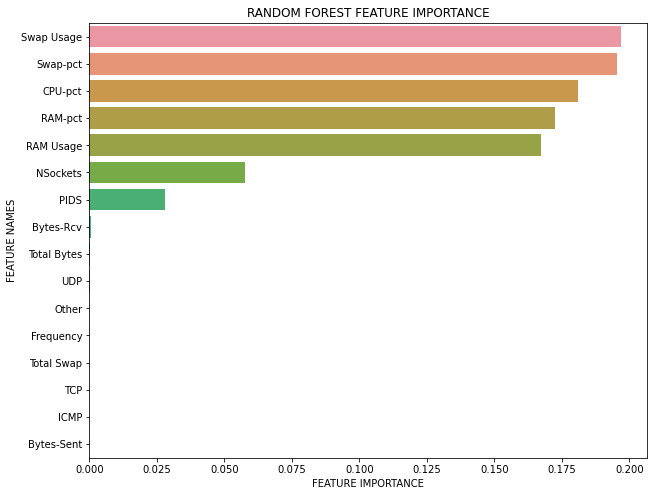

In [64]:
plot_feature_importance(clf.named_steps["classifier"].feature_importances_,df_ataque.columns[0:16],'RANDOM FOREST')

### Exporting the model

In [22]:
import joblib

joblib.dump(clf, 'man-in-the-middle-detection.pkl')

['man-in-the-middle-detection.pkl']

In [23]:
clf_prueba = joblib.load('man-in-the-middle-detection.pkl')
prediccion_prueba = clf_prueba.predict(X_test)